<a href="https://colab.research.google.com/github/AvantiShri/oceanography_colab_notebooks/blob/master/for_rian/ConstrainedWaterMassAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cvxpy as cp

In [2]:
!pip install gsw

In [3]:
import gsw



In [4]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ' -O names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv

--2020-10-08 18:38:35--  https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ
Resolving docs.google.com (docs.google.com)... 108.177.125.101, 108.177.125.139, 108.177.125.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.125.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9mu51h4m4q84rc1snqacjfgqv6jvbldb/1602182250000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download [following]
--2020-10-08 18:38:36--  https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9mu51h4m4q84rc1snqacjfgqv6jvbldb/1602182250000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download
Resolving doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to doc-0s-a4-docs.googleusercontent.com (doc-0s-

In [5]:
def augment_df_with_PO_NO_SiO(df):  
  #remineralization ratios
  r_PO = 155;
  r_SiO = 15
  r_NO = 9.68
  df["PO"] = df["oxygen"] + df["phosphate"]*r_PO
  df["NO"] = df["oxygen"] + df["nitrate"]*r_NO
  df["SiO"] = df["oxygen"] + df["silicate"]*r_SiO

In [6]:
import pandas as pd
import numpy as np

header = ["c"+str(i) for i in range(1,30)]
header[4] = "bottle flag"
header[16] = "bottle salinity flag"
header[20] = "bottle oxygen flag"
header[22] = "slicate flag"
header[24] = "nitrate flag"
header[28] = "phosphate flag"

header[11] = "CTD pressure"
header[12] = "CTD temperature"
header[15] = "practical_salinity" #practical salinity
header[8] = "latitude"
header[9] = "longitude"

header[0] = "stnnbr"
header[4] = "btl_flag"
header[5] = "geotrc_ID"
header[10] = "bottom depth"
header[19] = "oxygen"
header[21] = "silicate"
header[23] = "nitrate"
header[27] = "phosphate"

gp15_df = pd.read_csv("names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv",
                      names=header, na_values = -999)
augment_df_with_PO_NO_SiO(gp15_df)

absolute_salinity = gsw.SA_from_SP(SP=gp15_df["practical_salinity"],
                                   p=gp15_df["CTD pressure"],
                                   lon=gp15_df["longitude"],
                                   lat=gp15_df["latitude"])
gp15_df["absolute_salinity"] = absolute_salinity

conservative_temp = gsw.CT_from_t(SA=absolute_salinity,
                                  t=gp15_df["CTD temperature"],
                                  p=gp15_df["CTD pressure"])
gp15_df["conservative_temp"] = conservative_temp

potential_temp = gsw.pt_from_CT(SA=absolute_salinity,
                                CT=conservative_temp)
gp15_df["potential_temp"] = potential_temp

sig0 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=0) - 1000
gp15_df["sig0"] = sig0
sig1500 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=1500) - 1000
sig2000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=2000) - 1000
sig3000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=3000) - 1000
sig4000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=4000) - 1000

z = gsw.z_from_p(p=gp15_df["CTD pressure"], lat=gp15_df["latitude"])
depth = -z #https://github.com/TEOS-10/python-gsw/blob/7d6ebe8114c5d8b4a64268d36100a70e226afaf6/gsw/gibbs/conversions.py#L577
gp15_df["depth"] = depth

spic0 = gsw.spiciness0(SA=absolute_salinity, CT=conservative_temp)
gp15_df["spiciness"] = spic0

#calculation of planetary vorticity
rho_ref = 1000.0 #reference density
Omega = 2*np.pi/86400;
f = np.mean(2*Omega*np.sin(gp15_df["latitude"]*(np.pi/180.0)))
PV = -(f/rho_ref)*(np.gradient(sig0, depth))
gp15_df["PV"] = PV #potential vorticity

print("Rows:",len(gp15_df))
gp15_df = gp15_df.dropna()
print("Rows without NA values:",len(gp15_df))

gp15_df["mass"] = 1

Rows: 1143
Rows without NA values: 1124


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1061: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1062: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1063: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1069: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


In [7]:
# Next, define the end members for the intermediate OMPA and deep OMPA.
# Each row represents the hydrographic definitions of each water mass.
# The columns of data are the parameters listed here:
#
# [ temperature ; salinity ; oxygen ; phosphate ; silicate ;
#   nitrate; spiciness; vorticity]
#

def prepare_water_mass_df(water_mass_arr):
    df = pd.DataFrame(data=water_mass_arr,
                      columns=["watermassname",
                               "potential_temp", "practical_salinity",
                               "oxygen", "phosphate", "silicate",
                               "nitrate", "spiciness", "PV"])
    augment_df_with_PO_NO_SiO(df)
    df["mass"] = 1
    return df

                             #Temp  Sal     Oxy     Phos   Sili   Nitr    Spic      Vort
P16_Emilie_AAIW = ["AAIW",    5.68, 34.307, 237.0,  1.77,  16.60, 25.5,   0.068,    88.86E-12]
GLODAP_mystery =  ["Mystery", 2.09, 34.53,   36.1,  3.03, 168.87, 43.5,  -0.154,    26.95E-12]
GLODAP_NPIW =     ["NPIW",    4.72, 34,      81.8,  2.64,  79.87, 36.48, -0.262,   130.26E-12]
GLODAP_EqPIW =    ["EqPIW",   7.65, 34.60,   48.50, 2.71,  44.53, 38.26,  0.568,     0.01E-12]
P16_UCDW =        ["UCDW",    2.6,  34.575, 168,    2.4,   85.7,  34.4,  -0.1,      37.49E-12]
Emilie_P16_PDW =  ["PDW",     1.65, 34.641,	95,	   2.77, 175.9,	 40.1,  -0.123,    10.43E-12]
P16_LCDW =        ["LCDW",    1.62, 34.738, 195,    2.17,  96.6,  31,    -0.066,    12.55E-12]
GLODAP_AABW =     ["AABW",    0.18, 34.70,  219,    2.27, 124.45, 32.57, -0.203,     2.9E-12]

end_mem_intanddeep_df = prepare_water_mass_df(
    [P16_Emilie_AAIW,
     GLODAP_mystery,
     GLODAP_NPIW,
     GLODAP_EqPIW,
     P16_UCDW,
     Emilie_P16_PDW,
     P16_LCDW,
     GLODAP_AABW])

# Now, the end member definitions for the water masses now include the following parameters:
#  0      1      2      3       4      5      6     7     8      9       10
# [temp ; sal ; [O2] ; [PO4] ; [Si] ; [NO3] ; Spic; Vort; 'PO' ; 'SiO' ; 'NO' ]

In [8]:
max(gp15_df[(gp15_df["sig0"] <= 27.72)]["depth"])

2401.1070865746165

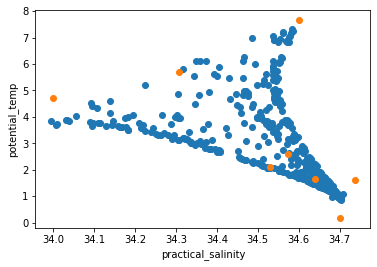

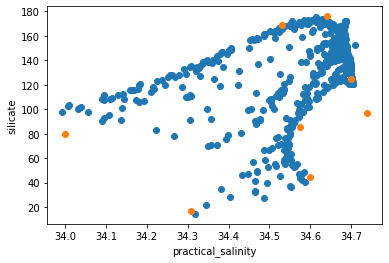

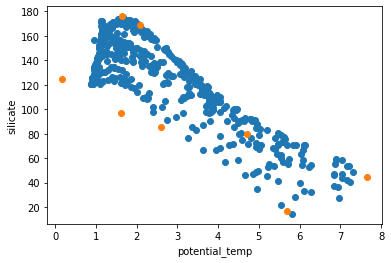

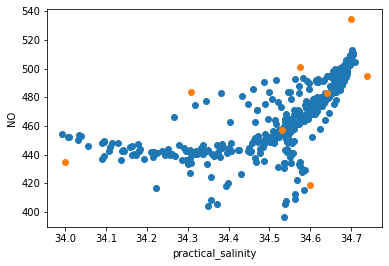

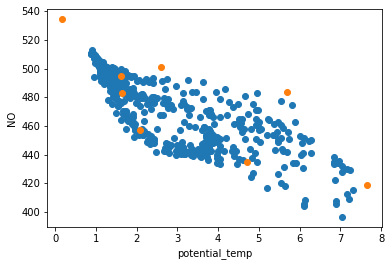

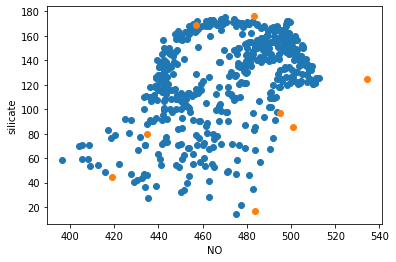

In [9]:
from matplotlib import pyplot as plt

#Make plots of intermedaite and deep waters
# to sanity-check

#Constrain to intermediate waters
# For intermedaite, also have (gp15_df["sig0"] <= 27.72)
gp15_intanddeep_df = gp15_df[(gp15_df["sig0"] >= 27.0)]

def plot_intanddeep(xaxis, yaxis):
  plt.scatter(gp15_intanddeep_df[xaxis],
              gp15_intanddeep_df[yaxis])
  plt.scatter(end_mem_intanddeep_df[xaxis],
              end_mem_intanddeep_df[yaxis])
  plt.xlabel(xaxis)
  plt.ylabel(yaxis)
  plt.show()

plot_intanddeep("practical_salinity", "potential_temp")
plot_intanddeep("practical_salinity", "silicate")
plot_intanddeep("potential_temp", "silicate")
plot_intanddeep("practical_salinity", "NO")
plot_intanddeep("potential_temp", "NO")
plot_intanddeep("NO", "silicate")

In [28]:
import scipy
import scipy.spatial

def spherical_to_surface_cartesian(lat, lon):
    r = 6.371*(1E3) #earth radius
    theta = ((1-lat)/180.0)*np.pi
    phi = (lon/180.0)*np.pi
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    return (x,y)

def add_surface_cartesian_coordinates_to_df(df):
    latitudes = df["latitude"]
    longitudes = df["longitude"]
    xs,ys = list(zip(*[spherical_to_surface_cartesian(*x)
                       for x in zip(latitudes, longitudes)]))
    df["x"] = xs
    df["y"] = ys
    #plt.scatter(xs, ys)
    #plt.show()

def compute_pairwise_distances_sigma0(df, sigma0scale):
    xs = df["x"]
    ys = df["y"]
    
    sigma0 = np.array(df["sig0"])
    sigma0_diffs = np.abs(sigma0[:,None] - sigma0[None,:])*sigma0scale

    #plt.hist(sigma0_diffs.ravel(), bins=20)
    #plt.show()

    coors = np.array([xs, ys]).transpose((1,0))
    euclidean_distances = scipy.spatial.distance.squareform(
        scipy.spatial.distance.pdist(coors))
    #plt.hist(euclidean_distances.ravel(), bins=100)
    #plt.show()

    weighted_distances = np.sqrt(np.square(euclidean_distances)
                                 + np.square(sigma0_diffs))
    #plt.hist(weighted_distances.ravel(), bins=20)
    #plt.show()
    return weighted_distances

add_surface_cartesian_coordinates_to_df(gp15_df)
pairwise_distances = compute_pairwise_distances_sigma0(gp15_df, 1000)

In [11]:
#Only points within 2k of each other should be considered
#np.percentile(pairwise_distances.ravel(), q=[0.1,1,5,10])


inter_yesaaiw_yesmystery 0 weighting1
params to use: ['potential_temp', 'practical_salinity', 'silicate', 'NO', 'spiciness', 'PV', 'mass']
param weighting: [140 100  30  10  10  10 140]
status: optimal
optimal value 719336.6574428491
inter_yesaaiw_yesmystery 1 weighting1
Adding cartesian coordiantes
Computing pairwise distances


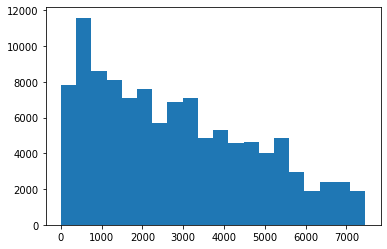

Constrained pairs: 1660


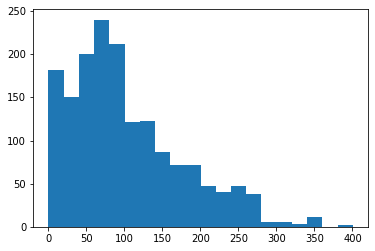

params to use: ['potential_temp', 'practical_salinity', 'silicate', 'NO', 'spiciness', 'PV', 'mass']
param weighting: [140 100  30  10  10  10 140]
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 14276, constraints m = 14608
          nnz(P) + nnz(A) = 62416
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00

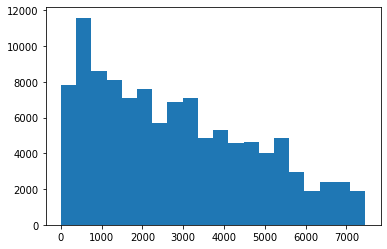

Constrained pairs: 1660


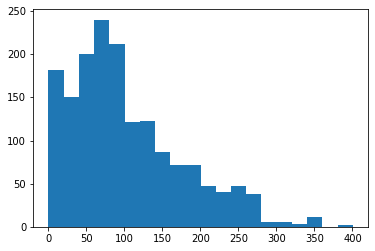

params to use: ['potential_temp', 'practical_salinity', 'silicate', 'NO', 'PV', 'mass']
param weighting: [280 300  30  10  10 140]
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 13944, constraints m = 14276
          nnz(P) + nnz(A) = 59760
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.04e+04   5.0

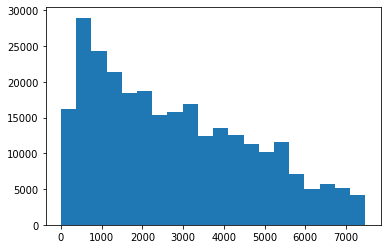

Constrained pairs: 2620


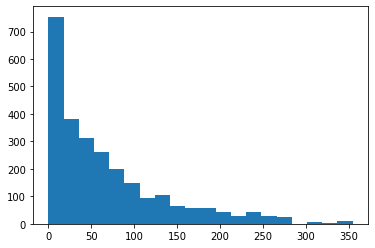

params to use: ['potential_temp', 'practical_salinity', 'silicate', 'NO', 'spiciness', 'PV', 'mass']
param weighting: [140 100  30  10  10  10 140]
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 28820, constraints m = 29344
          nnz(P) + nnz(A) = 128904
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+0

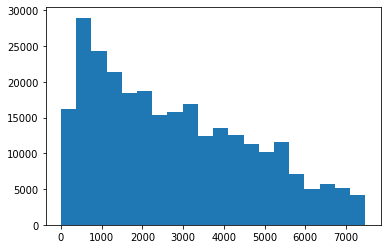

Constrained pairs: 2620


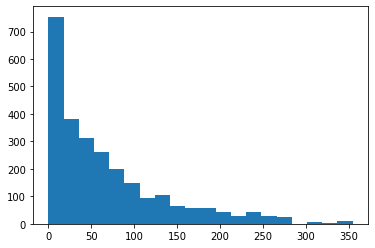

params to use: ['potential_temp', 'practical_salinity', 'silicate', 'NO', 'PV', 'mass']
param weighting: [280 300  30  10  10 140]
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 28296, constraints m = 28820
          nnz(P) + nnz(A) = 123664
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   1.04e+04   4.

In [80]:
from collections import OrderedDict


def compute_distance(coor1, coor2):
    #convert lat, lon, depth to spherical coordinates
    x1,x2,x3 = spherical_to_cartesian(coor1)
    x2,x3,x3 = spherical_to_cartesian(coor2)


class OMPAProblem(object):

    def __init__(self, watermass_df, obs_df, paramsandweighting,
                         enforce_mass_conservation,
                         smoothness_lambda,
                         nneighb=4,
                         sigma0scale=1000):
        self.watermass_df = watermass_df
        self.obs_df = obs_df
        self.paramsandweighting = paramsandweighting
        #split up the paramsandweighting into params and weighting
        self.params_to_use, self.weighting = [list(x) for x in 
                                              zip(*paramsandweighting)]
        self.enforce_mass_conservation = enforce_mass_conservation
        self.smoothness_lambda = smoothness_lambda
        self.nneighb = nneighb
        self.sigma0scale = sigma0scale

    def solve(self):

        watermass_df = self.watermass_df
        obs_df = pd.DataFrame(self.obs_df)
        params_to_use = self.params_to_use
        weighting = np.array(self.weighting)
        enforce_mass_conservation = self.enforce_mass_conservation
        nneighb = self.nneighb
        sigma0scale = self.sigma0scale

        if (smoothness_lambda > 0):
            print("Adding cartesian coordiantes")
            add_surface_cartesian_coordinates_to_df(obs_df)
            print("Computing pairwise distances")
            pairwise_distances = compute_pairwise_distances_sigma0(
                obs_df, sigma0scale=sigma0scale)
            plt.hist(pairwise_distances.ravel(), bins=20)
            plt.show()
            nneighb_thresh = np.sort(pairwise_distances, axis=-1)[:,nneighb+1]
            masked_pairwise_distances =\
              pairwise_distances*(pairwise_distances <= nneighb_thresh[:,None])
            #get the nonzero indices, make the pairs matrix
            # for the smoothness regularization
            pairs_to_consider_indices = np.nonzero(masked_pairwise_distances)
            print("Constrained pairs:",len(pairs_to_consider_indices[0]))
            #assert False
            pairs_distances = pairwise_distances[
                pairs_to_consider_indices[0],
                pairs_to_consider_indices[1]]
            plt.hist(pairs_distances.ravel(), bins=20)
            plt.show()
            pairs_matrix = np.zeros((len(pairs_to_consider_indices[0]),
                                     len(obs_df)))
            pairs_matrix[np.arange(len(pairs_distances)),
                         pairs_to_consider_indices[0]] = 1#(
                             #1000/pairs_distances)
            pairs_matrix[np.arange(len(pairs_distances)),
                         pairs_to_consider_indices[1]] = -1#-(
                             #1000/pairs_distances)
            
            
        #We are going to solve the following problem:
        # Minimize (x A - b)^2
        # Subject to x >= 0, x <= 1, cp.sum(x, axis=1) == 1
        # x has dimensions of observations X end_members
        # A has dimensions of end_members X parameteres
        # b has dimensions of observations X parameters

        #We also want a matrix that is [pairs X observations] <- S
        # S @ x --> pairs X end_member_diffs

        A = np.array(watermass_df[params_to_use])
        b = np.array(obs_df[params_to_use])

        #compute the variance of the parameters
        #param_variances = np.nanvar(b, axis=0)
        #apply a relative weighting
        #weighting = (1/param_variances)*relative_weighting
        weighting = weighting
        print("params to use:", params_to_use)
        print("param weighting:", weighting)

        A = A*weighting[None,:]
        b = b*weighting[None,:]

        x = cp.Variable(shape=(len(b), len(A)))
        obj = cp.sum_squares(x@A - b)
        if (smoothness_lambda > 0):
            #obj += smoothness_lambda*cp.sum(
            #        cp.norm(pairs_matrix@x, axis=1))
            obj += smoothness_lambda*cp.sum_squares(10*pairs_matrix@x)
            #obj += smoothness_lambda*cp.sum(cp.power(pairs_matrix@x,4))

        obj = cp.Minimize(obj)
        constraints = [x >= 0]
        if (enforce_mass_conservation):
            constraints.append(cp.sum(x,axis=1)==1)
        prob = cp.Problem(obj, constraints)
        if (smoothness_lambda > 0):
            prob.solve(verbose=True)
            #ECOS solver args: https://github.com/embotech/ecos-python/blob/49e127b29e7994d7936abdd0e7acc6c02957d8ed/src/ecosmodule.c#L126
        else:
            prob.solve()  # Returns the optimal value.
        print("status:", prob.status)
        print("optimal value", prob.value)

        param_reconstruction = (x.value@A)/weighting[None,:]
        param_residuals = b/weighting[None,:] - param_reconstruction

        self.water_mass_fractions = x.value
        self.param_reconstruction = param_reconstruction
        self.param_residuals = param_residuals


gp15_intermediate = gp15_df[(gp15_df["sig0"] >= 27.0) & (gp15_df["sig0"] <= 27.72)]
gp15_interanddeep = gp15_df[(gp15_df["sig0"] >= 27.0)]

intermediate_paramsandweighting = [("potential_temp",140),
                                   ("practical_salinity",100),
                                   ("silicate",30),
                                   ("NO",10),
                                   ("spiciness",10),
                                   ("PV",10),
                                   ("mass", 140)]

intermediate_paramsandweighting2 = [("potential_temp",2*140),
                                   ("practical_salinity",3*100),
                                   ("silicate",30),
                                   ("NO",10),
                                   #("spiciness",10),
                                   ("PV",10),
                                   ("mass", 140)]

watermassdfname_to_dfs = OrderedDict()

"""watermassdfname_to_dfs['inter_yesaaiw_nomystery'] =\
  (prepare_water_mass_df([P16_Emilie_AAIW,
                           GLODAP_NPIW,
                           GLODAP_EqPIW,
                           P16_UCDW,
                           Emilie_P16_PDW,
                          ]),
   gp15_intermediate)
watermassdfname_to_dfs['inter_noaaiw_yesmystery'] =\
  (prepare_water_mass_df([GLODAP_mystery,
                           GLODAP_NPIW,
                           GLODAP_EqPIW,
                           P16_UCDW,
                           Emilie_P16_PDW,
                          ]),
   gp15_intermediate[gp15_intermediate['latitude'] > 0])"""

watermassdfname_to_dfs['inter_yesaaiw_yesmystery'] =\
  (prepare_water_mass_df([P16_Emilie_AAIW,
                           GLODAP_mystery,
                           GLODAP_NPIW,
                           GLODAP_EqPIW,
                           P16_UCDW,
                           Emilie_P16_PDW,
                          ]),
   gp15_intermediate)
  
watermassdfname_to_dfs['interanddeep_all'] =\
  (prepare_water_mass_df([P16_Emilie_AAIW,
                           GLODAP_mystery,
                           GLODAP_NPIW,
                           GLODAP_EqPIW,
                           P16_UCDW,
                           Emilie_P16_PDW,
                           P16_LCDW,
                           GLODAP_AABW
                          ]),
   gp15_interanddeep)

ompa_setting_to_soln = OrderedDict()
for watermassdfname, (watermass_df, obs_df) in watermassdfname_to_dfs.items():
    for enforce_mass_conservation in [True]:#[False, True]:
        for (weightingname, weighting) in [("weighting1", intermediate_paramsandweighting),
                                               ("weighting2", intermediate_paramsandweighting2)]:
            for smoothness_lambda in [0,1]:
                print(watermassdfname, smoothness_lambda, weightingname)
                ompa_problem = OMPAProblem(
                  watermass_df = watermass_df,
                  obs_df = obs_df,
                  paramsandweighting=weighting,
                  enforce_mass_conservation=enforce_mass_conservation,
                  smoothness_lambda=smoothness_lambda)
                ompa_problem.solve()
                ompa_setting_to_soln[(watermassdfname,
                                      enforce_mass_conservation,
                                      smoothness_lambda,
                                      weightingname)] = ompa_problem


Plottin water mass fractions
Setting: ('inter_yesaaiw_yesmystery', True, 0, 'weighting1')


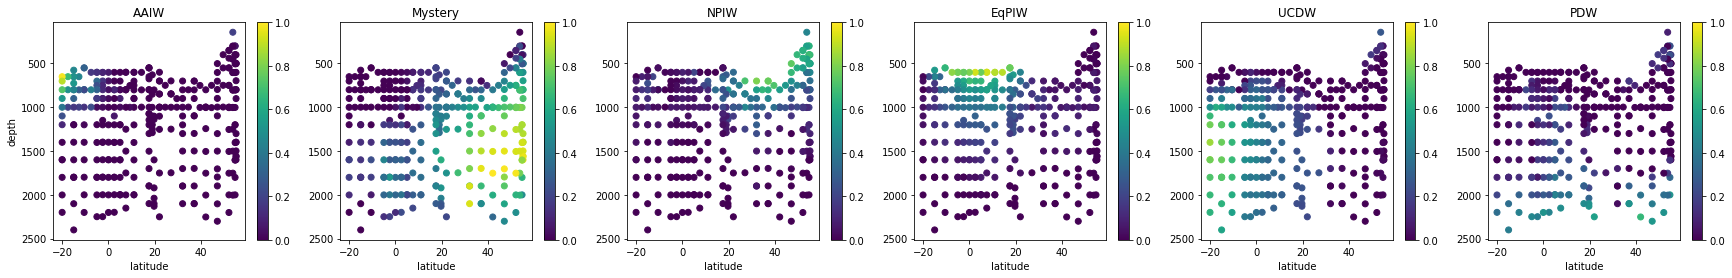

Setting: ('inter_yesaaiw_yesmystery', True, 1, 'weighting1')


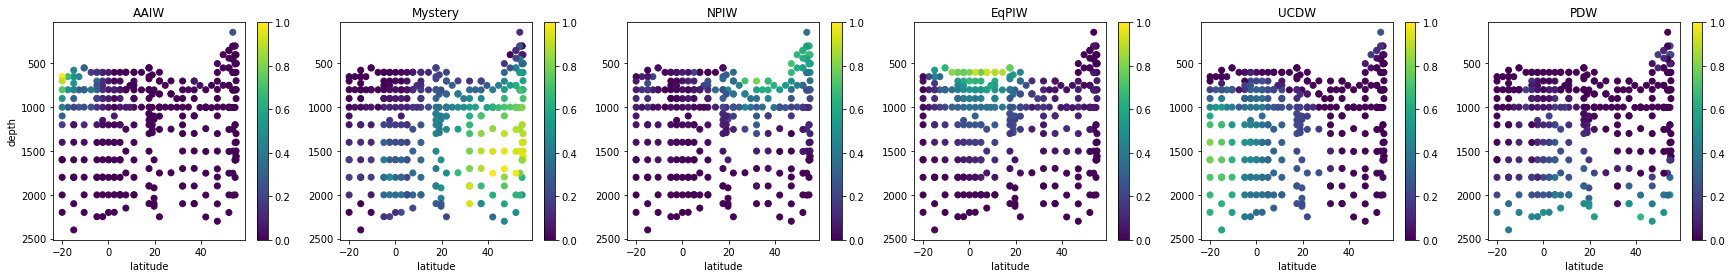

Setting: ('inter_yesaaiw_yesmystery', True, 0, 'weighting2')


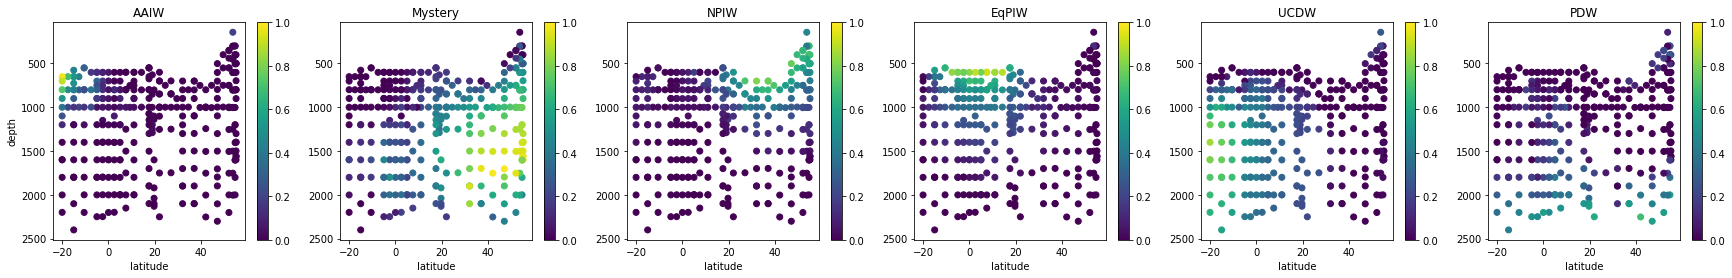

Setting: ('inter_yesaaiw_yesmystery', True, 1, 'weighting2')


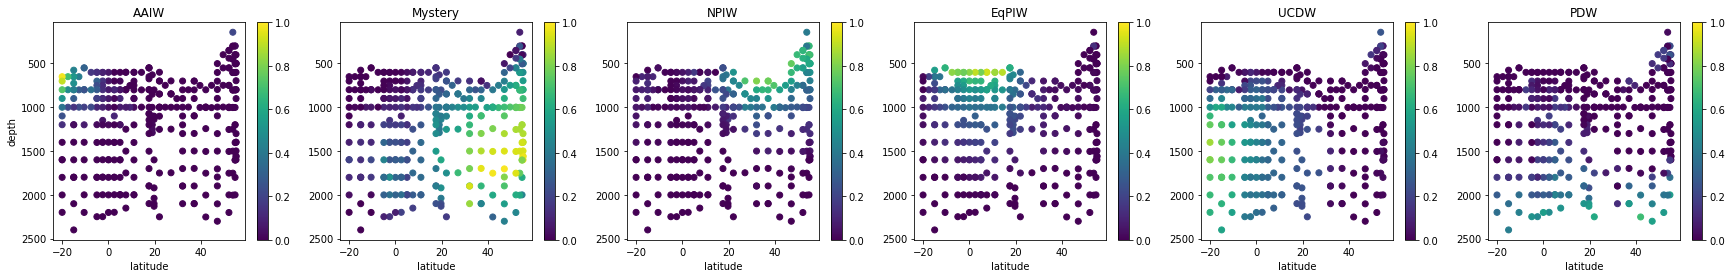

Setting: ('interanddeep_all', True, 0, 'weighting1')


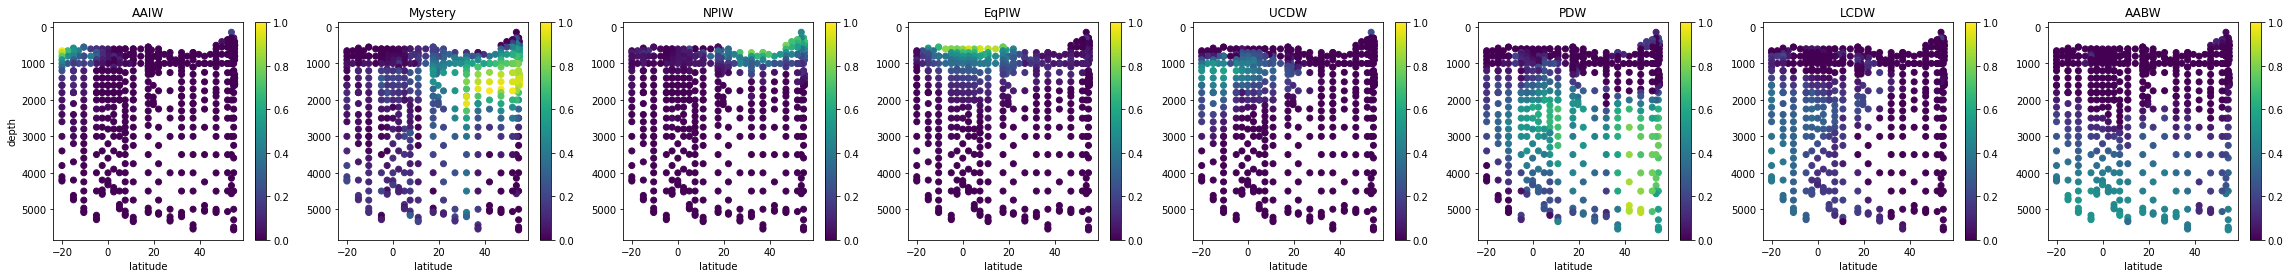

Setting: ('interanddeep_all', True, 1, 'weighting1')


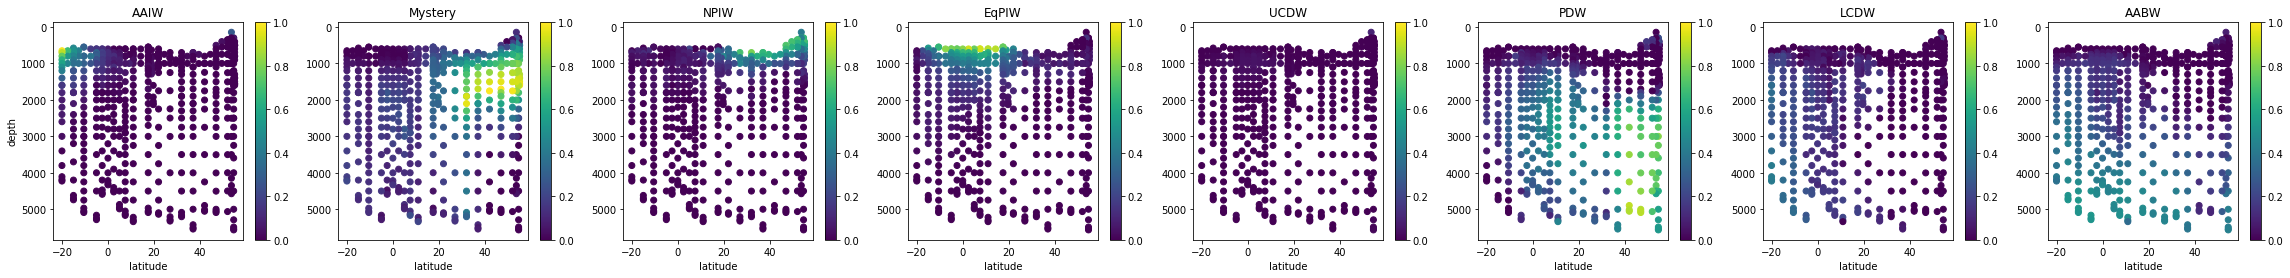

Setting: ('interanddeep_all', True, 0, 'weighting2')


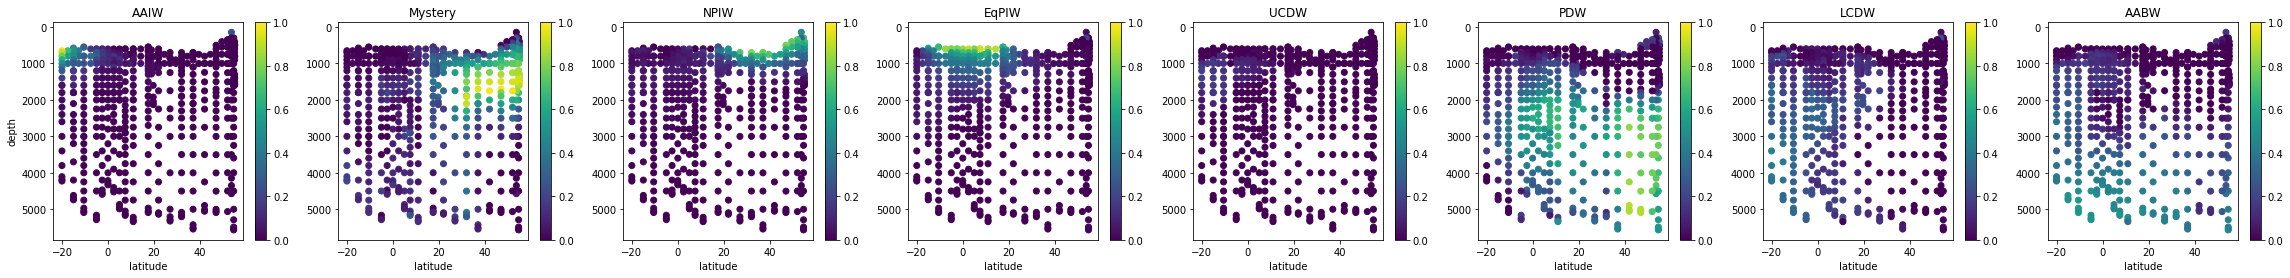

Setting: ('interanddeep_all', True, 1, 'weighting2')


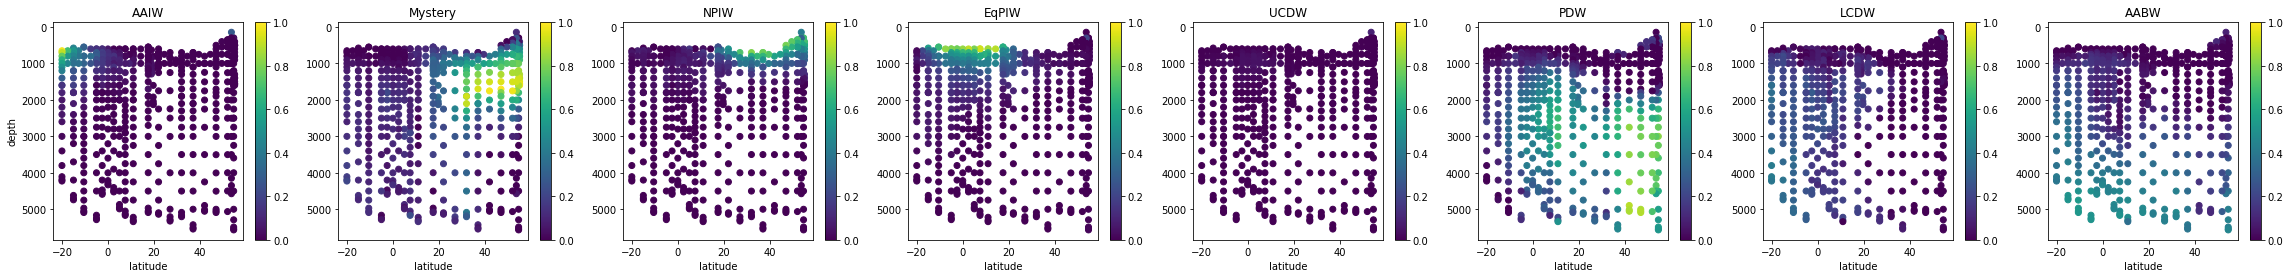

Plotting absolute residuals
Setting: ('inter_yesaaiw_yesmystery', True, 0, 'weighting1')


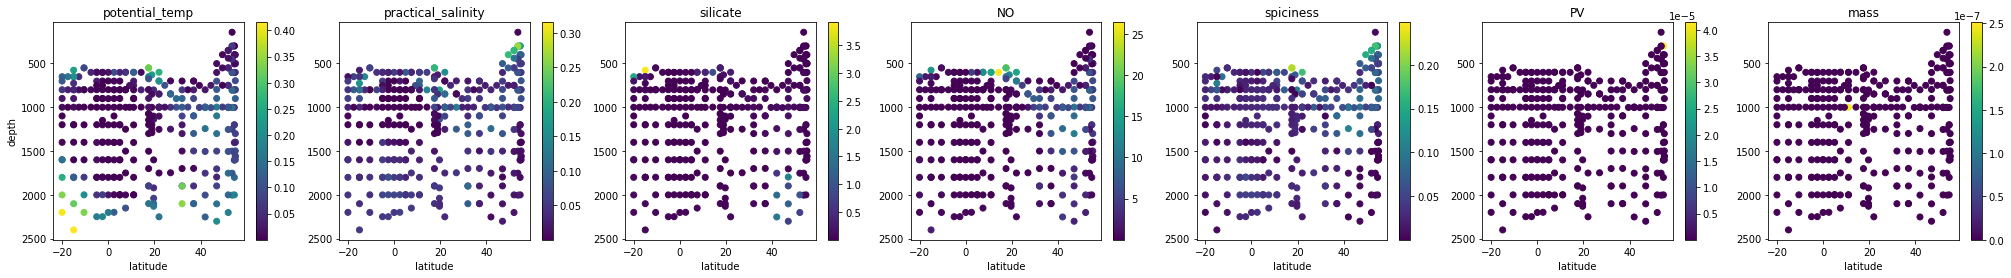

Setting: ('inter_yesaaiw_yesmystery', True, 1, 'weighting1')


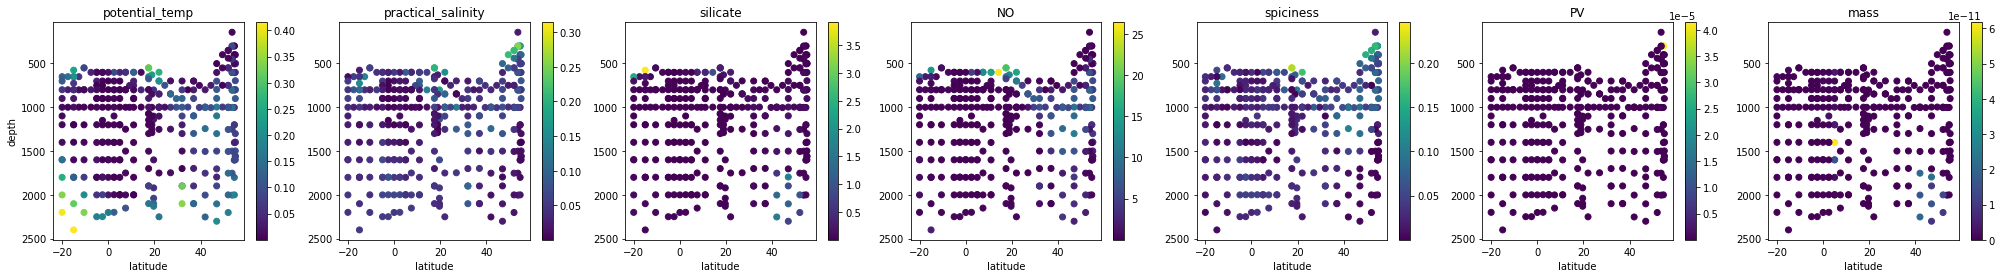

Setting: ('inter_yesaaiw_yesmystery', True, 0, 'weighting2')


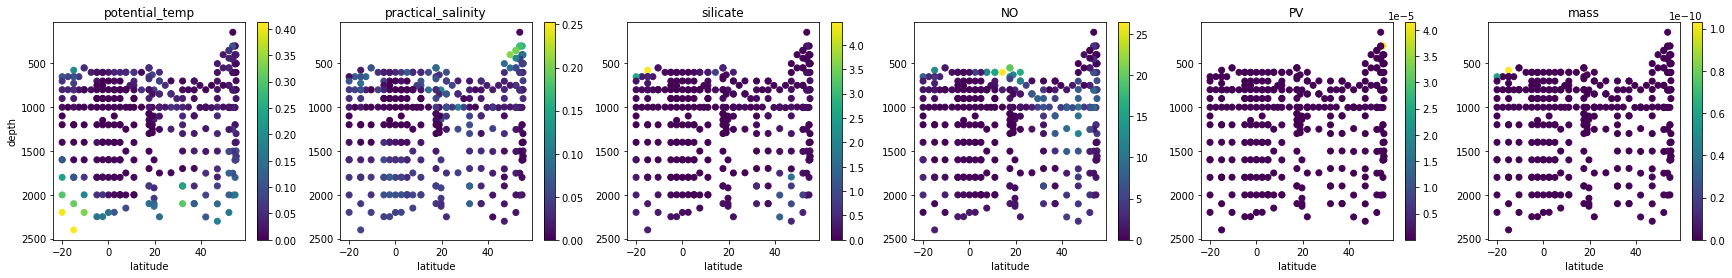

Setting: ('inter_yesaaiw_yesmystery', True, 1, 'weighting2')


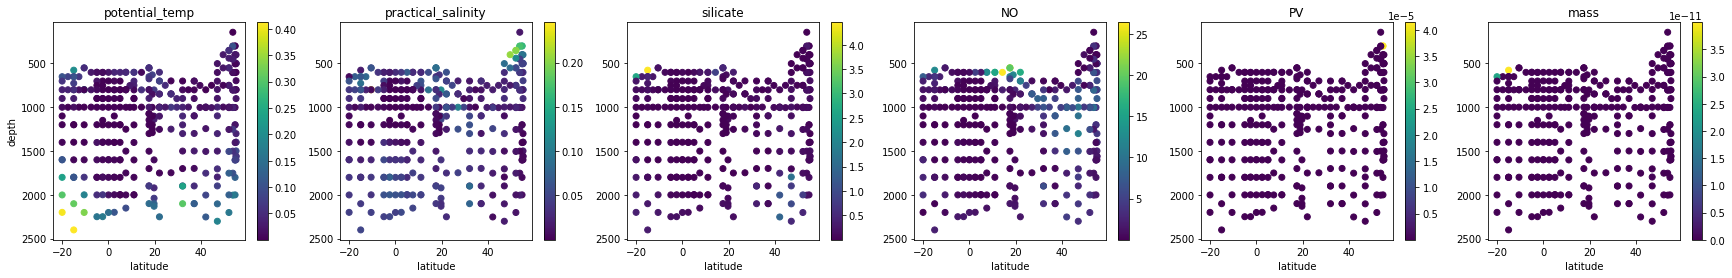

Setting: ('interanddeep_all', True, 0, 'weighting1')


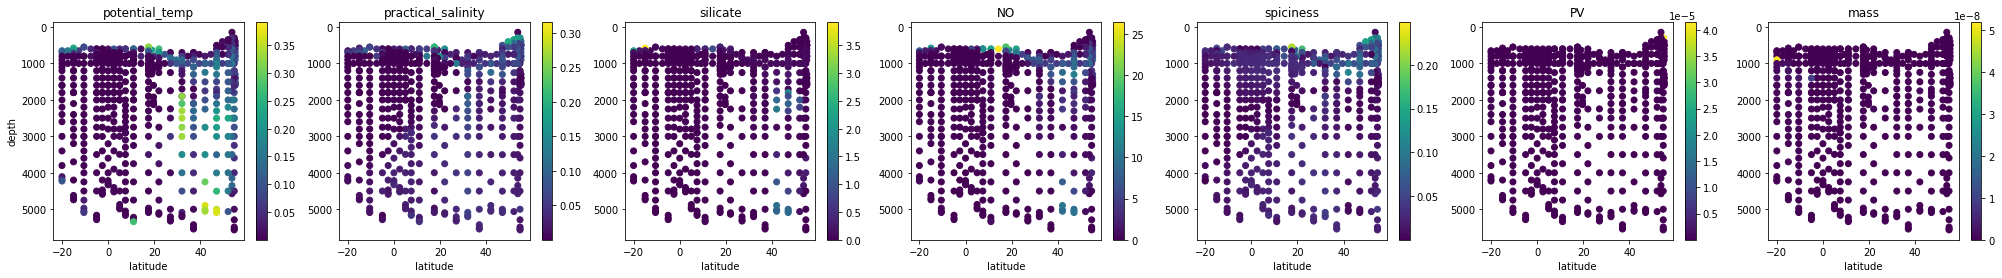

Setting: ('interanddeep_all', True, 1, 'weighting1')


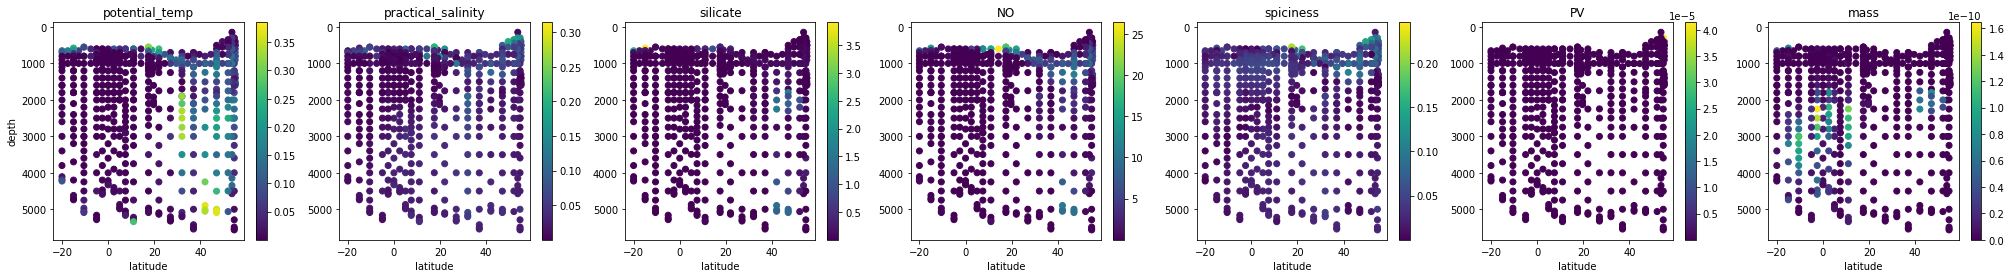

Setting: ('interanddeep_all', True, 0, 'weighting2')


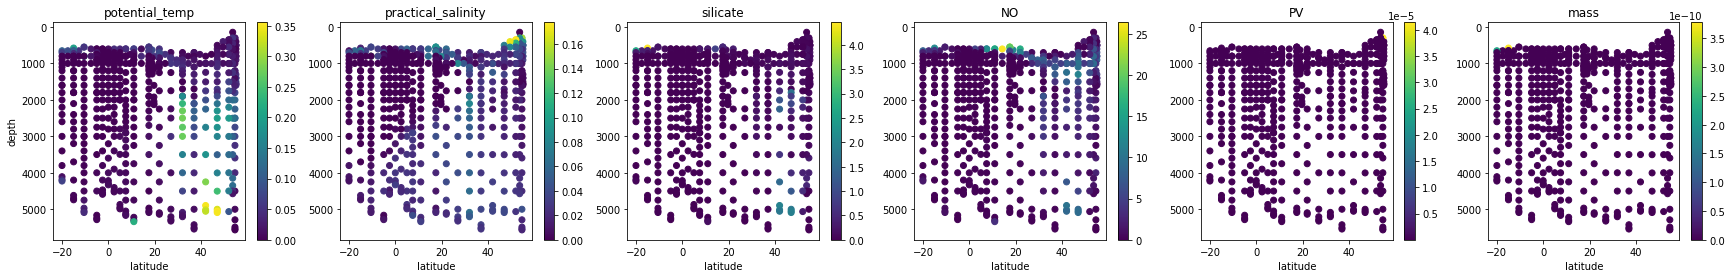

Setting: ('interanddeep_all', True, 1, 'weighting2')


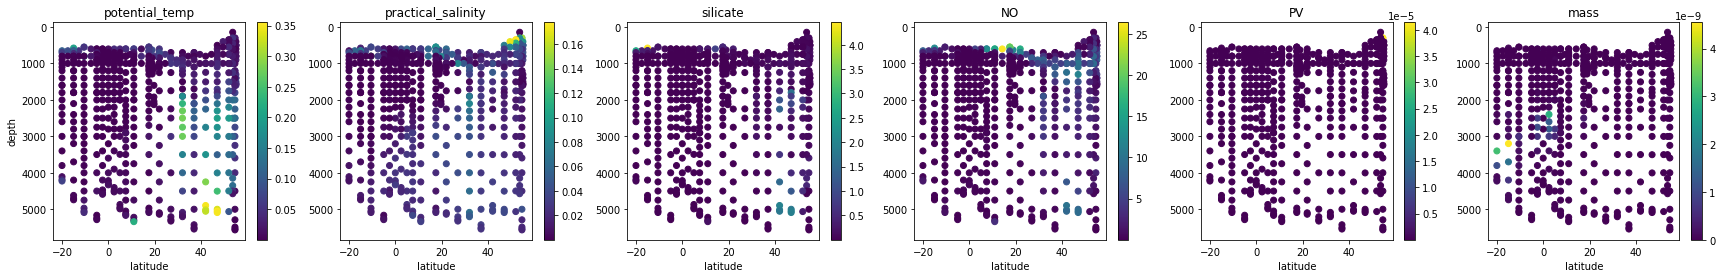

In [81]:
def plot_water_mass_fractions(ompa_problem):
    num_watermasses = ompa_problem.water_mass_fractions.shape[1]
    fig, ax = plt.subplots(nrows=1, ncols=num_watermasses,
                           figsize=(5*num_watermasses,4))
    for i in range(num_watermasses):
        plt.sca(ax[i])
        plt.scatter(ompa_problem.obs_df["latitude"],
                    ompa_problem.obs_df["depth"],
                    c=ompa_problem.water_mass_fractions[:,i])
        plt.xlabel("latitude")
        if (i==0):
            plt.ylabel("depth")
        plt.ylim(plt.ylim()[1], plt.ylim()[0])
        plt.colorbar()
        plt.clim(0,1)
        plt.title(ompa_problem.watermass_df["watermassname"][i])
    plt.show()


def plot_residuals(ompa_problem):
    num_params = ompa_problem.param_residuals.shape[1]
    fig, ax = plt.subplots(nrows=1, ncols=num_params,
                           figsize=(5*num_params,4))
    for i in range(ompa_problem.param_residuals.shape[1]):
        plt.sca(ax[i])
        plt.scatter(x=ompa_problem.obs_df["latitude"],
                    y=ompa_problem.obs_df["depth"],
                    c=np.abs(ompa_problem.param_residuals[:,i]),
                    cmap="viridis")
        plt.colorbar()
        plt.xlabel("latitude")
        if (i==0):
          plt.ylabel("depth")
        plt.ylim(plt.ylim()[1], plt.ylim()[0])
        plt.title(ompa_problem.params_to_use[i])
    plt.show()


print("Plottin water mass fractions")
for setting in ompa_setting_to_soln:
    print("Setting:", setting)
    plot_water_mass_fractions(ompa_setting_to_soln[setting])

print("Plotting absolute residuals")
for setting in ompa_setting_to_soln:
    print("Setting:", setting)
    plot_residuals(ompa_setting_to_soln[setting])  